<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA22/blob/main/python/C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Divided differences using sparse matrix

Import the usual modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

New module: sparse algebra

In [2]:
import scipy.sparse as sp

Function implementing the forward difference in sparse format

In [3]:
def forward_difference(a, b, N):
  h = (b-a)/N
 
  # Compute FD matrix as sparse using Compressed Sparse Row (CSR) format 
  data = [-np.ones(N+1), np.ones(N)]
  FD = sp.diags(data,[0,1], format="csr")
  return FD / h

In [4]:
a=0
b=1
N=5
FD = forward_difference(a, b, N)

In [5]:
print (FD)

  (0, 0)	-5.0
  (0, 1)	5.0
  (1, 1)	-5.0
  (1, 2)	5.0
  (2, 2)	-5.0
  (2, 3)	5.0
  (3, 3)	-5.0
  (3, 4)	5.0
  (4, 4)	-5.0
  (4, 5)	5.0
  (5, 5)	-5.0


In [6]:
print(FD.todense())

[[-5.  5.  0.  0.  0.  0.]
 [ 0. -5.  5.  0.  0.  0.]
 [ 0.  0. -5.  5.  0.  0.]
 [ 0.  0.  0. -5.  5.  0.]
 [ 0.  0.  0.  0. -5.  5.]
 [ 0.  0.  0.  0.  0. -5.]]


Use the FD to evaluate the derivative of $f(x)=\frac{x^2}{2}$

In [7]:
t = sym.var('t')
my_f = 0.5 * t**2
fsym = sym.lambdify(t, my_f )

a=0 
b=1
N = 100

# Evaluate FD matrix
FD = forward_difference(a, b, N)

# Values of the derivative at the 
# internal grid points
x=np.linspace(0,1,N+1)

%timeit u_x = FD.dot(fsym(x))[1:N]

# Print results
#print(u_x)

11.4 µs ± 4.75 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


**Exercise.** Find a way to evaluate execution time and compare full vs sparse exectution time

# Central finite differences in 1D

Poisson problem in 1D:

$-u''(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$

We use the second central divided difference to approxima the second derivative.

Given $h>0$, 

$u''(x)≈\frac{u(x+h)-2u(x)+u(x-h)}{h^2}$

Function for second central matrix

In [8]:
def CD2(N):
  # Function defining nominator of
  # second central FD formula on a 
  # uniform grid in sparse CSR format
  data = [np.ones(N), -2 * np.ones(N+1), np.ones(N)]
  return sp.diags(data,[-1,0,1], format="csr")

In [9]:
N = 5
A = CD2(N)

print(A.todense())

[[-2.  1.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  1. -2.]]


Test problem:

$(a,b)=(0,\pi)$

u(x)=sin(x)

In [10]:
# Define right-hand side function
t = sym.var('t')
my_f = sym.sin(t)
rhs_f = sym.lambdify(t, my_f )

# Define exact solution
my_sol = sym.sin(t)
exact_sol = sym.lambdify(t, my_sol )

Define FD problem:

for $h=(b-a)/N$

$ A U = - h^2 F $

with $A$ the nominator of CD formula.

In [11]:
# Problem domain
a = 0
b= np.pi

# Size of grid
N = 20
h = (b-a)/N

# Grid
x = np.linspace(a,b,N+1)

# CD matrix
A = CD2(N)

# Right-hand side
F = - h**2 * rhs_f(x[1:-1])

# Homogeneous Dirichlet boundary conditions
A = A[1:-1,1:-1]


Import solver

In [12]:
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve

Solve problem and print result

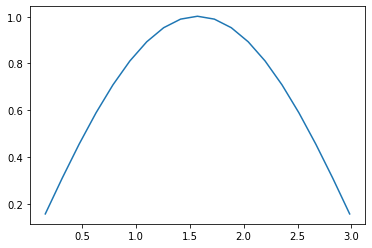

In [13]:
# Compute solution at internal nodes
FD_sol = spsolve(A,F)

# plot solution
plt.plot(x[1:-1],FD_sol)

In [14]:
# print max error

print(np.max(np.abs(FD_sol-exact_sol(x[1:-1]))))

0.002058706764533902


**Exercise 1.** test for convergence and plot convergence plot

We repeat what done before for increasingly higher values of N, then plot the error and see if it goes to 0.

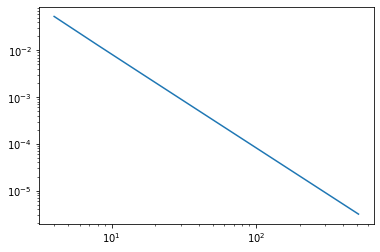

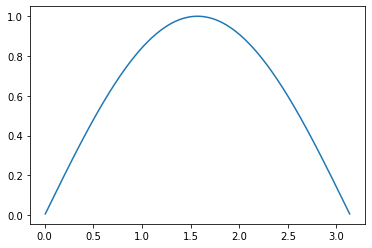

In [17]:
# Define right-hand side function
t = sym.var('t')
my_f = sym.sin(t)
rhs_f = sym.lambdify(t, my_f )

# Define exact solution
my_sol = sym.sin(t)
exact_sol = sym.lambdify(t, my_sol )

# Problem domain
a = 0
b= np.pi

Nvals=[]
errors=[]

for i in range(2,10):
    # Size of grid
    N=2**i
    Nvals.append(N)
    h = (b-a)/N
    # Grid
    x = np.linspace(a,b,N+1)
    # CD matrix
    A = CD2(N)
    # Right-hand side
    F = - h**2 * rhs_f(x[1:-1])
    # Homogeneous Dirichlet boundary conditions
    A = A[1:-1,1:-1]
    # Compute solution at internal nodes
    FD_sol = spsolve(A,F)
    error=np.max(np.abs(FD_sol-exact_sol(x[1:-1])))
    errors.append(error)
plt.loglog(Nvals,errors)
plt.show()
plt.plot(x[1:-1],FD_sol)

**Exercise 2.** Solve the problem with nonhomogeneous Dirichlet conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=\frac{1}{2}$

In [18]:
# Define right-hand side function
alpha=1/2
t = sym.var('t')
my_f = (1/alpha) *sym.sin(t)
rhs_f = sym.lambdify(t, my_f )

# Define exact solution
my_sol = (1/alpha) *sym.sin(t)
exact_sol = sym.lambdify(t, my_sol )


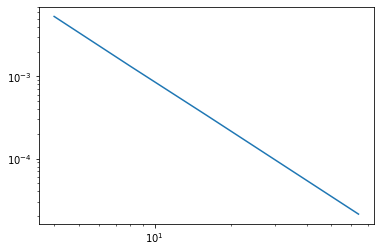

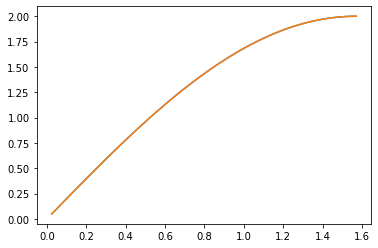

In [19]:
# Problem domain
a = 0
b= np.pi/2

#Boundary condition
u_a=0
u_b=exact_sol(np.pi/2)

Nvals=[]
errors=[]

for i in range(2,7):
    # Size of grid
    N=2**i
    Nvals.append(N)
    h = (b-a)/N
    # Grid
    x = np.linspace(a,b,N+1)
    # CD matrix
    A = CD2(N)
    # Right-hand side
    F = - h**2 * rhs_f(x[1:-1])
    # NON Homogeneous Dirichlet boundary conditions
    A = A[1:,1:]
    A[-1,-1]=1
    A[-1,-2]=0
    F=np.concatenate((F,[u_b]),0)
    # Compute solution at internal nodes
    FD_sol = spsolve(A,F)
    error=np.max(np.abs(FD_sol-exact_sol(x[1:])))
    errors.append(error)
plt.loglog(Nvals,errors)
plt.show()
plt.plot(x[1:],FD_sol)
plt.plot(x[1:],exact_sol(x[1:]))

**Exercise 3.** Solve the problem with (homogeneous) Neumann conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u'(b)=0$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=1$.

In [20]:
# Define right-hand side function
alpha=1
u_a=1
t = sym.var('t')
my_f = (1/alpha) *sym.sin(t)
rhs_f = sym.lambdify(t, my_f )

# Define exact solution
my_sol = (1/alpha) *sym.sin(t)+u_a
exact_sol = sym.lambdify(t, my_sol )


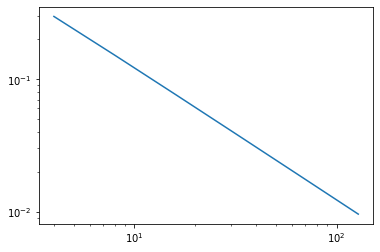

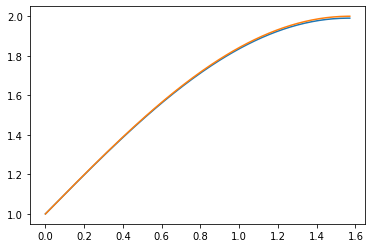

In [21]:
# Problem domain
a = 0
b= np.pi/2

#Boundary condition
u_a=1

Nvals=[]
errors=[]

for i in range(2,8):
    # Size of grid
    N=2**i
    Nvals.append(N)
    h = (b-a)/N
    # Grid
    x = np.linspace(a,b,N+1)
    # CD matrix
    A = CD2(N)
    # Right-hand side
    F = - h**2 * rhs_f(x[1:-1])
    # NON Homogeneous Dirichlet boundary conditions in a and Homogeneous Neumann in b
    A[0,0]= 1
    A[0,1]=0
    A[-1,-1]=1
    A[-1,-2]=-1
    F=np.concatenate(([u_a],F,[0]),0)
    # Compute solution at internal nodes
    FD_sol = spsolve(A,F)
    error=np.max(np.abs(FD_sol-exact_sol(x)))
    errors.append(error)
plt.loglog(Nvals,errors)
plt.show()
plt.plot(x,FD_sol)
plt.plot(x,exact_sol(x))

**Exercise 4.** Solve the reaction-advection-diffusion problem (still with central differences):

$-\alpha u''(x)+\beta u'(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$


In [21]:
#definition of the matrices
a=0
b=np.pi/2
alpha=1
beta=1
gamma=1

# CD matrix for second derivative
N=5
h = (b-a)/N
A = -(1/h**2)*CD2(N)

# CD matrix for first derivative
B=forward_difference(a,b,N)

#matrix for the problem
M=-alpha*A+beta*B+gamma*np.eye(N+1)

print("A=",A.todense(),"\n\n\n","B=",B.todense(),"\n\n\n","M=",M)

A= [[ 20.26423673 -10.13211836   0.           0.           0.
    0.        ]
 [-10.13211836  20.26423673 -10.13211836   0.           0.
    0.        ]
 [  0.         -10.13211836  20.26423673 -10.13211836   0.
    0.        ]
 [  0.           0.         -10.13211836  20.26423673 -10.13211836
    0.        ]
 [  0.           0.           0.         -10.13211836  20.26423673
  -10.13211836]
 [  0.           0.           0.           0.         -10.13211836
   20.26423673]] 


 B= [[-3.18309886  3.18309886  0.          0.          0.          0.        ]
 [ 0.         -3.18309886  3.18309886  0.          0.          0.        ]
 [ 0.          0.         -3.18309886  3.18309886  0.          0.        ]
 [ 0.          0.          0.         -3.18309886  3.18309886  0.        ]
 [ 0.          0.          0.          0.         -3.18309886  3.18309886]
 [ 0.          0.          0.          0.          0.         -3.18309886]] 


 M= [[-22.44733559  13.31521723   0.           0.           0

In [22]:
#definition of the data
alpha=-1
beta=0
gamma=1

#for this case we take F=0 so that the solution is again the sinus, since sin''(t)=-sin(t)

# Define exact solution
my_sol = sym.sin(t)
exact_sol = sym.lambdify(t, my_sol )


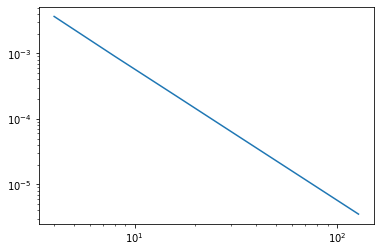

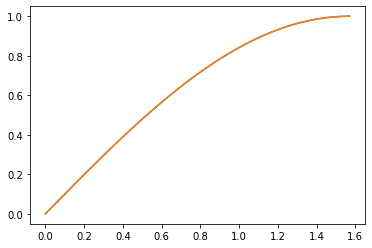

In [23]:
#problem domain
a=0
b=np.pi/2

#Boundary condition
u_a=0
u_b=1

Nvals=[]
errors=[]
times=[]

for i in range(2,8):
    # Size of grid
    N=2**i
    Nvals.append(N)
    h = (b-a)/N
    # Grid
    x = np.linspace(a,b,N+1)

    # CD matrix for second derivative
    A = (1/h**2)*CD2(N)   

    # CD matrix for first derivative
    B=forward_difference(a,b,N)

    #matrix for the problem
    M=-alpha*A+beta*B+gamma*np.eye(N+1)

    #Right hand side
    F=np.zeros(N+1)
    F[0]=u_a
    F[-1]=u_b
    # NON Homogeneous Dirichlet boundary conditions in a and in b
    M[0,0]= 1
    M[0,1]=0
    M[-1,-1]=1
    M[-1,-2]=0

    # Compute solution at internal nodes
    FD_sol = solve(M,F)
    error=np.max(np.abs(FD_sol-exact_sol(x)))
    errors.append(error)
plt.loglog(Nvals,errors)
plt.show()
plt.plot(x,FD_sol)
plt.plot(x,exact_sol(x))

**Exercise 5.** Now take any of the problems above, but this time with data such that you do not know the exact solution. How would you test the order of convergence of the FD method?

In [24]:
#definition of the data
alpha=2
beta=5
gamma=1
#problem domain
a=0
b=np.pi/2

#Boundary condition
u_a=1
u_b=1

Nvals=[]
errors=[]
times=[]
for i in range(2,10):
    # Size of grid
    N=2**i
    Nvals.append(N)
    h = (b-a)/N
    # Grid
    x = np.linspace(a,b,N+1)

    # CD matrix for second derivative
    A = (1/h**2)*CD2(N)   

    # CD matrix for first derivative
    B=forward_difference(a,b,N)

    #matrix for the problem
    M=-alpha*A+beta*B+gamma*np.eye(N+1)

    #Right hand side
    F=np.zeros(N+1)
    F[0]=u_a
    F[-1]=u_b
    # NON Homogeneous Dirichlet boundary conditions in a and in b
    M[0,0]= 1
    M[0,1]=0
    M[-1,-1]=1
    M[-1,-2]=0

    # Compute solution at internal nodes
    FD_sol = spsolve(M,F)
    if i==3:
        FD_sol_old=np.zeros_like(FD_sol)

    #to compute the residual we consider the difference between iterations of the algorithm
    error=np.max( [np.abs(FD_sol[2*j]-FD_sol_old[j]) for j in range(int(N/2))])
    errors.append(error)
    FD_sol_old=FD_sol
plt.loglog(Nvals,errors)
plt.show()
plt.plot(x,FD_sol)

C:\Users\lollopc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


NameError: name 'FD_sol_old' is not defined

**Exersie 6.** Consider again the problem from Exercise 4.

Fix $a=0$, $b=1$, $u_a=1$, $u_b=0$ $f=0$.

Try first with $\alpha=\beta=\gamma=1$ and plot the solution.

Next, try with $\alpha=0.01$, and $\beta=1$, $\gamma=0$. What happens? Can you explain?

C:\Users\lollopc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


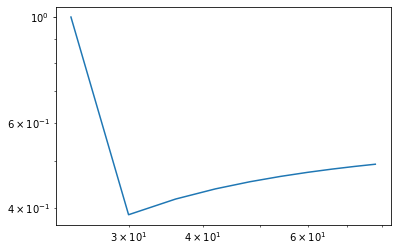

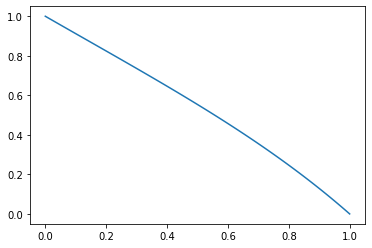

In [32]:
#Definition of the data
alpha=1
beta=1
gamma=1
#problem domain
a=0
b=1

#Boundary condition
u_a=1
u_b=0

Nvals=[]
errors=[]
times=[]
FD_sol_old=np.zeros(40)
for i in range(4,14):
    # Size of grid
    N=6*i
    Nvals.append(N)
    h = (b-a)/N
    # Grid
    x = np.linspace(a,b,N+1)

    # CD matrix for second derivative
    A = (1/h**2)*CD2(N)   

    # CD matrix for first derivative
    B=forward_difference(a,b,N)

    #matrix for the problem
    M=-alpha*A+beta*B+gamma*np.eye(N+1)

    #Right hand side
    F=np.zeros(N+1)
    F[0]=u_a
    F[-1]=u_b
    # NON Homogeneous Dirichlet boundary conditions in a and in b
    M[0,0]= 1
    M[0,1]=0
    M[-1,-1]=1
    M[-1,-2]=0

    # Compute solution at internal nodes
    FD_sol = spsolve(M,F)
    if i==3:
        FD_sol_old=np.zeros_like(FD_sol)

    #to compute the residual we consider the difference between iterations of the algorithm
    error=np.max( [np.abs(FD_sol[2*j]-FD_sol_old[j]) for j in range(int(N/2))])
    errors.append(error)
    FD_sol_old=FD_sol
   
plt.loglog(Nvals,errors)
plt.show()
plt.plot(x,FD_sol)

N= 30 

h^2= 0.0011111111111111111 

M= [[-12.  21.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [ -9. -12.  21.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [  0.  -9. -12.  21.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [  0.   0.  -9. -12.  21.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [  0.   0.   0.  -9. -12.  21.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [  0.   0.   0.   0.  -9. -12.  21.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.

C:\Users\lollopc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


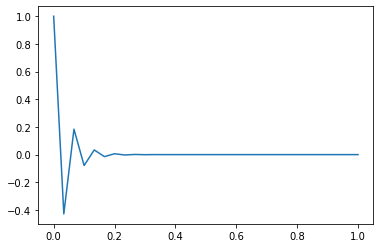

N= 40 

h^2= 0.0006250000000000001 

M= [[ -8.  24.   0. ...   0.   0.   0.]
 [-16.  -8.  24. ...   0.   0.   0.]
 [  0. -16.  -8. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  -8.  24.   0.]
 [  0.   0.   0. ... -16.  -8.  24.]
 [  0.   0.   0. ...   0. -16.  -8.]] 



C:\Users\lollopc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


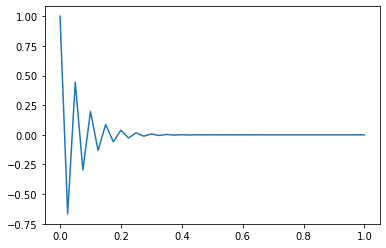

N= 50 

h^2= 0.0004 

M= [[  0.  25.   0. ...   0.   0.   0.]
 [-25.   0.  25. ...   0.   0.   0.]
 [  0. -25.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.  25.   0.]
 [  0.   0.   0. ... -25.   0.  25.]
 [  0.   0.   0. ...   0. -25.   0.]] 



C:\Users\lollopc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
C:\Users\lollopc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


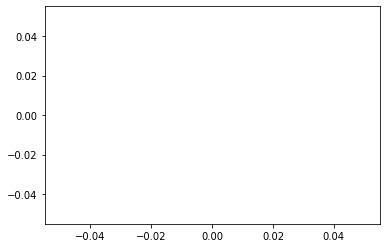

N= 60 

h^2= 0.0002777777777777778 

M= [[ 12.  24.   0. ...   0.   0.   0.]
 [-36.  12.  24. ...   0.   0.   0.]
 [  0. -36.  12. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  12.  24.   0.]
 [  0.   0.   0. ... -36.  12.  24.]
 [  0.   0.   0. ...   0. -36.  12.]] 



C:\Users\lollopc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


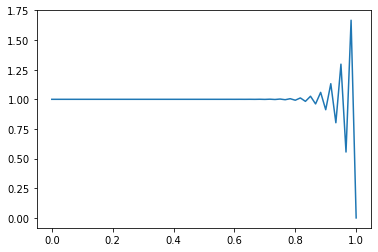

N= 70 

h^2= 0.0002040816326530612 

M= [[ 28.  21.   0. ...   0.   0.   0.]
 [-49.  28.  21. ...   0.   0.   0.]
 [  0. -49.  28. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  28.  21.   0.]
 [  0.   0.   0. ... -49.  28.  21.]
 [  0.   0.   0. ...   0. -49.  28.]] 



C:\Users\lollopc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


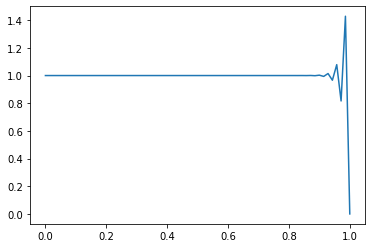

In [34]:
#Definition of the data
alpha=0.01
beta=1
gamma=0
#problem domain
a=0
b=1

#Boundary condition
u_a=1
u_b=0

Nvals=[]
errors=[]
times=[]
#FD_sol_old=np.zeros(100)
for i in range(3,8):
    # Size of grid
    N=10*i
    print("N=",N,"\n")
    Nvals.append(N)
    h = (b-a)/N
    print("h^2=",h**2,"\n")
    # Grid
    x = np.linspace(a,b,N+1)

    # CD matrix for second derivative
    A = (1/h**2)*CD2(N)   

    # CD matrix for first derivative
    B=forward_difference(a,b,N)

    #matrix for the problem
    M=-alpha*A+beta*B+gamma*np.eye(N+1)
    print("M=",M,"\n")
    #Right hand side
    F=np.zeros(N+1)
    F[0]=u_a
    F[-1]=u_b
    # NON Homogeneous Dirichlet boundary conditions in a and in b
    M[0,0]= 1
    M[0,1]=0
    M[-1,-1]=1
    M[-1,-2]=0

    # Compute solution at internal nodes
    FD_sol = spsolve(M,F)
        

    #to compute the residual we consider the difference between iterations of the algorithm
    #error=np.max( [np.abs(FD_sol[2*j]-FD_sol_old[j]) for j in range(int(N/2))])
    #errors.append(error)
    #FD_sol_old=FD_sol
   
    plt.plot(x,FD_sol)
    plt.show()
#plt.loglog(Nvals,errors)
#plt.show()
#plt.plot(x,FD_sol)

A we can see the behavior changes abruptly at $N=50$ this corresponds to a change in the properties of the matrix M. For $N<50$ the diagonal elements are negative, then at $N=50$ it becomes degenerate and for $N>50$ the diagonal elements are positive and the matrix becomes elliptic again